设置部分

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

#输入基础内容图像和风格参考图像的下载路径，这里以巴黎城市和梵高的星空图像为例子
base_image_path = keras.utils.get_file("paris.jpg", "https://keras.io/img/examples/generative/neural_style_transfer/neural_style_transfer_5_0.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://keras.io/img/examples/generative/neural_style_transfer/neural_style_transfer_5_1.jpg")
result_prefix = "paris_generated"

# 不同损失成分的权重
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# 生成的图片的尺寸
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

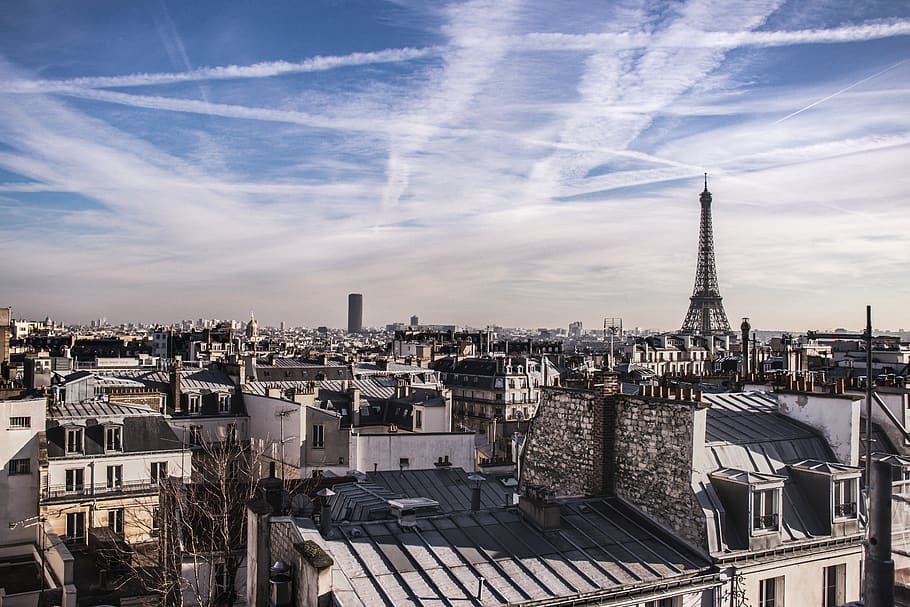

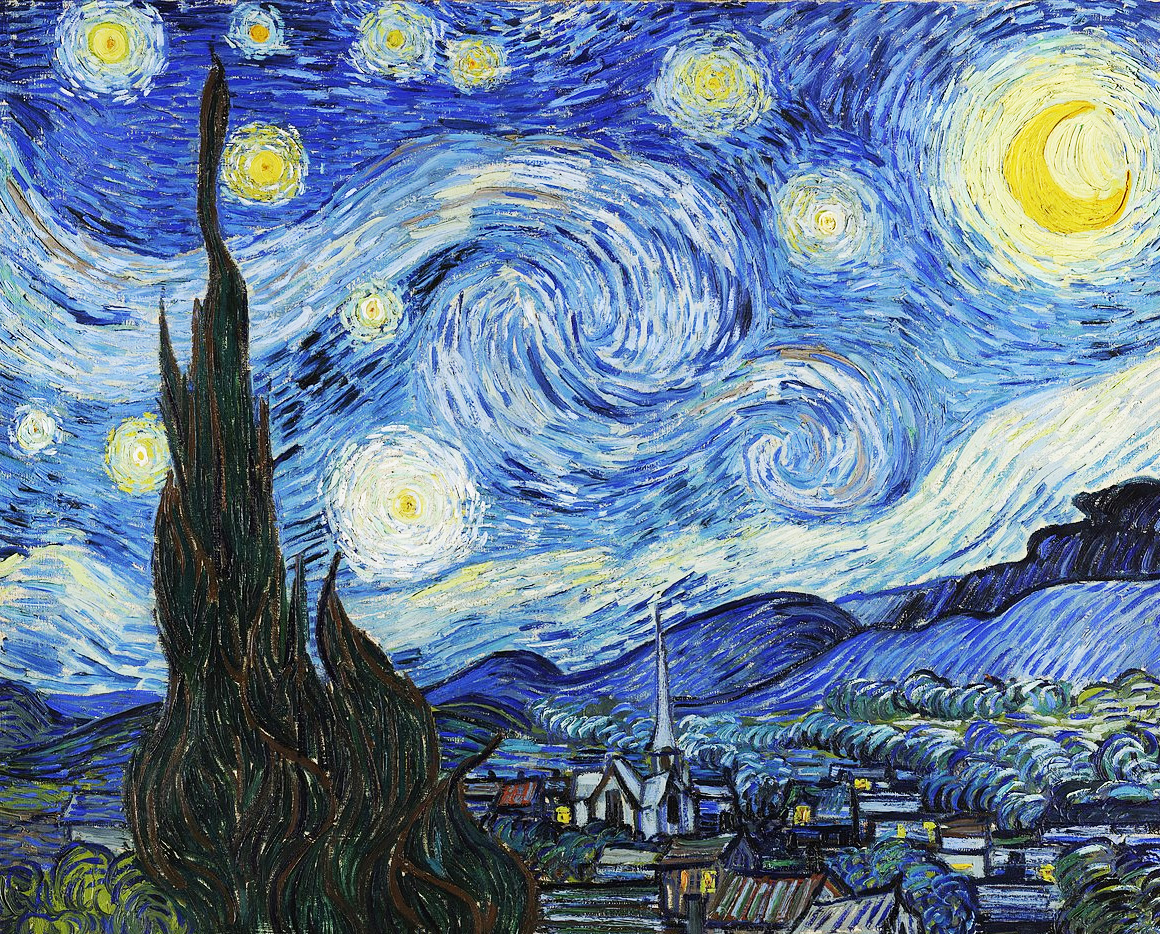

In [3]:
#查看一下基础内容图像和风格参考图像
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

图像预处理/反处理实用程序

In [6]:
#预处理图像的函数，用于打开、调整图片大小和格式化为适当张量的实用函数
#将输入图像变成能够被VGG19模型处理的样式
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


# 将张量转换为有效图像的实用函数
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


计算样式迁移损失
首先，我们需要定义 4 个实用函数：

gram_matrix（用于计算样式损失）；

style_loss函数，使生成的图像接近本地风格样式参考图像

content_loss函数，保留了生成的图像接近基础图像的图像

total_variation_loss函数是一种正则化损失，它使生成的图像保持局部相关，使其更贴近自然图像

In [10]:
# 图像张量的 gram 矩阵（特征外积）

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram



# 风格损失函数style loss旨在使生成的图像保持参考图的风格
# 它基于来自风格参考图和生成图像的特征列表的gram矩阵，计算风格图的gram矩阵与生成图的gram矩阵的L2距离，再乘以归一化常数
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# 内容损失函数content_loss旨在在生成的图像中维护基础图像的“内容”
# 将内容图和生成图分别由预训练CNN运行，获得各自中间层的特征，然后求两个特征的L2距离
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# 第三个函数, 全局像素平滑损失函数total variation loss
# 它的作用是平滑像素点，防止噪声，使图像更贴近自然图像
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

接下来，创建一个检索中间激活的特征提取模型 的 VGG19 （作为字典，按名称）

In [12]:
# 构建一个加载了预先训练的 ImageNet 权重的 VGG19 模型
model = vgg19.VGG19(weights="imagenet", include_top=False)

# 获取每个“关键”层的符号输出（赋予它们唯一的名称）。
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 建立一个模型，返回 VGG19 中每一层的激活值（作为字典）。
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

融合三个损失函数，计算 style transfer loss：

In [15]:
def compute_loss(combination_image, base_image, style_reference_image):
    # 用于风格损失的层列表，选取这些层的中间结果计算风格损失
    style_layer_names = [
        "block1_conv1",
        "block2_conv1",
        "block3_conv1",
        "block4_conv1",
        "block5_conv1",
    ]
    
    
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # 初始化损失
    loss = tf.zeros(shape=())

    # 用于内容丢失的层
    content_layer_name = "block5_conv2"
    # 添加内容损失，选取VGG19的block5_conv2层中间特征计算内容损失函数
    # 用到了内容图与生成图的中间结果
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # 添加风格损失
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # 添加总变异损失
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

在损失和梯度计算中添加一个tf.function装饰器，编译它，从而使其更快

In [20]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    #获取损失函数值以及损失函数值相对于生成图每一个像素的梯度
    return loss, grads

训练循环

重复运行 vanilla 梯度下降步骤以最大程度地减少损失，并保存 生成的图像。

每 15 步将学习率衰减 0.97。

In [24]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=300.0, decay_steps=15, decay_rate=0.97
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 150
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 15 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 15: loss=24851.91
Iteration 30: loss=13292.63
Iteration 45: loss=10362.63
Iteration 60: loss=9786.76
Iteration 75: loss=9083.56
Iteration 90: loss=8357.30
Iteration 105: loss=8109.83
Iteration 120: loss=7552.76
Iteration 135: loss=7681.54
Iteration 150: loss=7293.49


经过 150 次迭代后，得到以下结果：

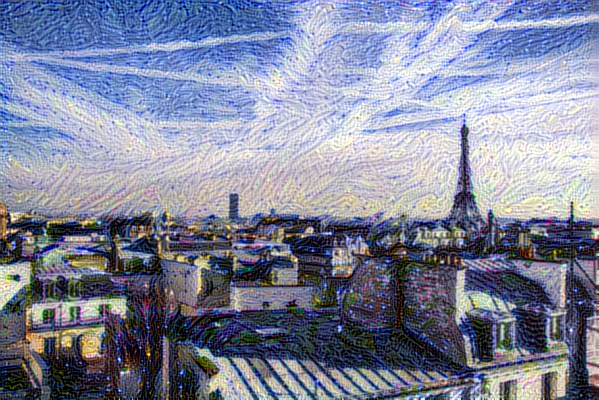

In [27]:
display(Image(result_prefix + "_at_iteration_150.png"))

和原内容图像对比：

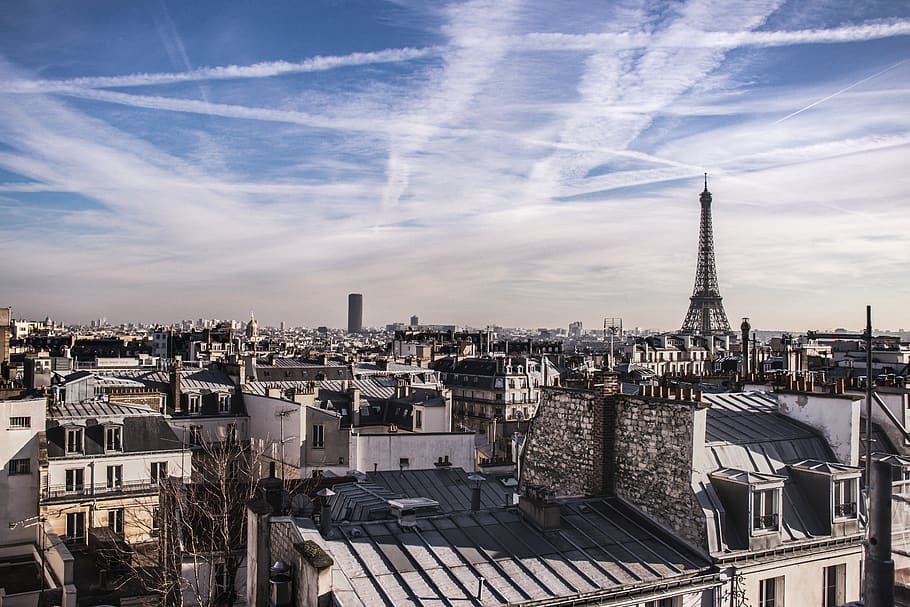

In [30]:
display(Image(base_image_path))